Trabajo ejemplo tomado del curso de inteligencia artificial IA2023II. El ejemplo está construido con un conjunto de datos disponible en Kaggle: https://www.kaggle.com/datasets/mdhrumil/english-dutch-text-classification-nlp-beginner/

# Introduccion
A continuacion se presentara el trabajo final de la asignatura inteligencia artificial, a lo largo de el desarrollo de las tematicas de la asignatura aprendimos acerca de los diversos metodos para aplicar la inteligencia artificial y la forma en la que estos se clasifican.
a lo largo de la ultima seccion del curso nos centramos especificamente en el machine learning, entiendase como machine learning a "la capacidad de predecir el futuro, por ejemplo, el peso de un vaso que vamos a levantar o la reacción de los demás a nuestros actos, en base a los patrones almacenados en la memoria" segun Jeff Hawkins  en su libro Sobre la inteligencia (publicado en 2004).
Dicha rama de la programacion se divide en 3 grupos de estudio:
* Aprendizaje supervisado.
* Aprendizaje no supervisado.
* Aprendizaje por Refuerzo.
Y durante el desarrollo de la seccion nos centraremos en el aprendizaje supervisado, aplicando conocidos metodos de aprendizaje supervisado como lo son:
* Arboles de desicion.
* Random Forest.
* Redes neuronales.
Para ello seguiremos los pasos para aplicar los metodos y las recomendaciones vistas en clase.

# Desarrollo
Antes de comenzar, consideramos necesario explicar los metodos y bases teoricas, sirviendonos a manera de guia a lo largo de la implementacion practica de los metodos anteriormente mencionados.

## Bases teoricas
Como mencionamos con anterioridad estudiaremos metodos de aprendizaje supervisado, pero resulta necesario comprenderlo mas a fondo para mejorar la comprension del trabajo.

### Aprendizaje supervisado
El aprendizaje supervisado cuenta con una estrategia basada en funciones y predicciones a partir de estas mismas, estos metodos intentan entrenar el modelo con un conjunto de datos de entrenamientos, los cuales cuentan tanto con variables independientes como con variables dependientes, y se basan en identificar las variables independientes y por medio de una serie de mecanismos identificar una fucion que logre retornar la variable dependiente correspondiente a los datos.
Podemos ver una explicacion mas grafica en el siguiente diagrama.
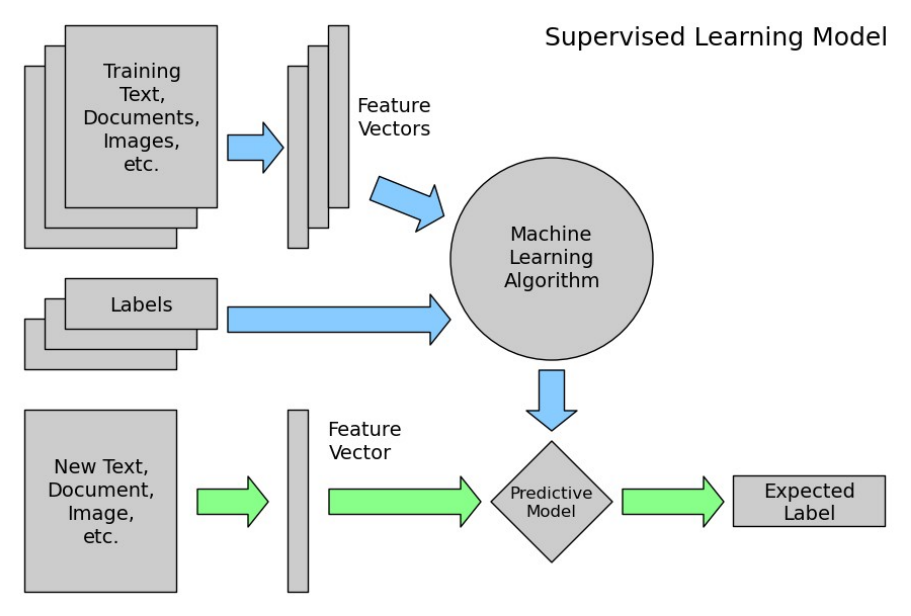

### Proceso de aplicacion de machine learning
El machine learning, al ser un campo con tantos años de estudio, cuenta con un debido proceso para lograr darle solucion a un problema, este proceso cuenta con una serie de pasos, los cuales aplicaremos a continuacion a manera de guia, permitiendonos solucionar el problema planteado de una manera organizada y sencilla, dichos pasos son:
* Formular la pregunta.
* Obtener y entender los datos.
* Limpiar los datos.
* Seleccionar el o los modelos.
* Ajustar y evaluar los modelos.
* Utilizar el modelo y mostrar los resultados.

## Descripción del problema
Para el desarrollo del problema contaremos con un registro de datos obtenidos de kaggle y tomados a su vez de articulos aleatorios de wikipedia, compilados en el archivo llamado train_new.txt, este cuenta con dos columnas, en la cual podemos ver un texto en ingles o holandes y una palabra "en" o "nl" la cual representa el idioma en el que esta escrito dicho texto.

A lo largo del trabajo se predenten analizar las oraciones de los diferentes idiomas tomadas de nuestra fuente, con el objetivo de clasificar un subconjunto de prueba a partir del entrenamiento recibido empleando otro subconjunto de entrenamiento logrando asi clasificar el texto proporcionado entre las dos clases (ingles y holandes), utilizando los metodos anteriormente mencionados.
en la siguiente seccion abordaremos con mayor profundidad el conjunto de datos y el significado de estos mismos.

Finalizando asi con la obtencion de las mejores configuraciones para cada metodo e identificando el metodo mas eficiente para llevar a cabo la tarea de clasificacion.

### Objetivos generales:

* Aplicar procesar el conjunto de datos.
* Implementar los modelos de aprendizaje de máquina.
* Realizar análisis y evaluar los resultados de los metodos.

### objetivos especificos:

* darle formato al conjunto de datos en una estructura computacional.
* eliminar los caracteres especiales y numericos.
* eliminar las palabras innecesarias (estas pueden ser palabras monosilabas, stopwords o palabras repetidas en ambos idiomas).
* Implementar funciones que nos faciliten el procesamiento de los datos en los modelos.
* implementar y analizar los resultados de la implementacion del modelo de arboles de desicion.
* implementar y analizar los resultados de la implementacion del modelo de bosque random.
* implementar y analizar los resultados de la implementacion del modelo de redes neuronales.
* implementar y analizar los resultados de la implementacion del modelo de redes neuronales profundas.
* analizar los resultados de las implementaciones y llevar a cabo una conclusion.

## Descripción de variables
El conjunto de datos tomado de Kaggle es un dataset que está conformado por dos columnas la primera conluna se llama "Language" y la segunda "Text".

* Variable objetivo Y: corresponde a la columna 'Language' del DataFrame df. Esta columna contiene la etiqueta del lenguaje ('en' o 'nl') asociada a cada texto.
* Variable predictora X: corresponde a la columna 'Text' del DataFrame df. Esta columna contiene el texto recopilado de los articulos de wikipedia.

## implementacion
a continuacion se llevara a cabo la solucion del problema abordando los procedimientos practicos desde las bases teoricas vistos en la subseccion de **Proceso de aplicacion de machine learning** ubicado en la seccion de **Bases teoricas**

### Formular la pregunta.
¿Cual es el lenguaje correspondiente al texto ingresado (ingles o español)?

### Obtener y entender los datos:
Importando las librerias:

In [1036]:
# Tratamiento de datos
import time
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

In [1037]:
# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

In [1038]:
# Preprocesado y modelado
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 

In [1039]:
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

lectura del archivo

In [1040]:
# Ruta del archivo CSV en Google Drive
rt_reviews = "train_new.txt"

In [1041]:
# Leer el archivo CSV en un DataFrame
df = pd.read_csv(rt_reviews, encoding='ISO-8859-1', sep="|")
df.columns = ["Language", "Text"]

In [1042]:
# Verificar que los datos se hayan cargado correctamente
print(df.head())

  Language                                               Text
0       en  and Africa in permission winners,[25] of in ye...
1       en  President tournament wearing presenting were m...
2       en  The the are 'The thirty-eight reference as Ell...
3       en  a The Rugby In and Warrant head 'The Webb and ...
4       en  an high - The game engraved Crown Football two...


### Limpiar los datos:
A partir de este punto buscaremos la manera de limpiar los datos de una forma que sea mas facil procesarlos para el modelo, para ello limpiaremos la cadena de texto correspondiente a la columna "text" del Dataframe df, eliminando los caracteres especiales, numeros y convirtiendo la cadena a minusculas.
ademas de hacer dos pruebas con el objetivo de optimizar el remdimiento de los modelos.

Primera prueba:
es bien sabido que las stopwords, tambien conocidas como palabras vacias, son una parte importante de un lenguaje, ya que estan conformadas por preposiciones, pronombres, conectores y de mas recursos linguisticos.
es por ello que nos enfrentamos a una dificil decicion, la cual podemos afrontar a partir de dos politicas.
* primera politica seria no eliminar las stopwords debido a que estas son un factor importante para determinar el lenguaje al que pertenece un texto, sin embargo esto podria representar un esfuerzo computacional mayor el cual no justificaria la poca precicion obtenida.
* segunda politica seria eliminar las stopwords debido a que representan un gran porcentaje del total de palabras, aunque esto podria afectar la precicion del modelo.
para dar solucion a dicho problema decidimos evaluar ambas politicas al entrenar y probar un modelo con las mismas variables y una entrada de texto diferente (con stopwords y sin stopwords).

Preparando los datos para probar las politicas

In [1043]:
#definiendo la funcion para eliminar stopwords en ingles
def remove_posE(tokens):
    # Obtener la lista de stopwords (incluye preposiciones) en inglés
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    pronouns = set()
    tagged_words = pos_tag(stopwords)
    for word, tag in tagged_words:
        if tag.startswith('PRP'):
            pronouns.add(word)
    
    tagged_tokens = pos_tag(tokens)
    tokens_without_pos = [token[0] for token in tagged_tokens if token[0] not in stopwords and token[0] not in pronouns]
    
    return tokens_without_pos

In [1044]:
#definiendo la funcion para eliminar stopwords en holandes
def remove_posH(tokens):
    # Obtener la lista de stopwords (incluye preposiciones) en holandes
    stopwords = set(nltk.corpus.stopwords.words('dutch'))
    
    pronouns = set()
    tagged_words = pos_tag(stopwords)
    for word, tag in tagged_words:
        if tag.startswith('PRP'):
            pronouns.add(word)
    
    tagged_tokens = pos_tag(tokens)
    tokens_without_pos = [token[0] for token in tagged_tokens if token[0] not in stopwords and token[0] not in pronouns]
    
    return tokens_without_pos

In [1045]:
#limpiando los datos
def limpiar_tokenizar(stopwords,lang,texto):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()

    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\.\\/\\:\\;\\<\\<<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    if(stopwords):
        # Eliminar preposiciones, pronombres y stopWords
        if(lang=="en"):
            nuevo_texto = remove_posE(nuevo_texto)
        else:
            nuevo_texto = remove_posH(nuevo_texto)
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if token.isalnum()]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token.lower() for token in nuevo_texto ]
    return nuevo_texto

In [1046]:
dfCopy = df.copy()
#guardando los datos con stopwords
df['texto_tokenizado'] = df.apply(
    lambda x: limpiar_tokenizar(False,x[0],x[1]), axis=1)
df.to_csv(
    'resultadoTokeniz.csv', index=False)

textFinal = df.explode(column='texto_tokenizado')
textFinal = textFinal.drop(columns='Text')
textFinal = textFinal.rename(columns={'texto_tokenizado': 'token'})


#guardando los datos con stopwords
dfCopy['texto_tokenizado'] = dfCopy.apply(
    lambda x: limpiar_tokenizar(True,x[0],x[1]), axis=1)
dfCopy.to_csv(
    'resultadoTokenizCopy.csv', index=False)

textFinalCopy = dfCopy.explode(column='texto_tokenizado')
textFinalCopy = textFinalCopy.drop(columns='Text')
textFinalCopy = textFinalCopy.rename(columns={'texto_tokenizado': 'token'})
palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])

print(f"Palabras en Ingles: {len(palabrasEn)}, Palabras en Holandes: {len(palabrasEn)}, comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras en Ingles: 2626, Palabras en Holandes: 2626, comunes entre Ingles y Holandes: 164


Realizando pruebas con las dos politicas:

In [1047]:
def to_array(x):
    item=x[2]
    item=item.replace("'", "")
    item=  item.strip('][').split(', ')
    return item
#conjunto con stopwords
ruta_archivo = r'./resultadoTokeniz.csv'
# Leer el archivo CSV
df = pd.read_csv(ruta_archivo, nrows=100000)


#conjunto sin stopwords
ruta_archivoCopy = r'./resultadoTokenizCopy.csv'

# Leer el archivo CSV
dfCopy = pd.read_csv(ruta_archivo, nrows=100000)

#conjunto con stopwords
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)

#conjuntos sin stopwords
datos_XCopy = dfCopy['texto_tokenizado']
datos_yCopy = dfCopy['Language']

print(datos_XCopy.unique())
print(datos_yCopy.unique())

X_trainCopy, X_testCopy, y_trainCopy, y_testCopy = train_test_split(
    datos_XCopy,
    datos_yCopy,
    test_size=0.80,
    random_state=42
)

# Crear una instancia del vectorizador para el conjunto con stopwords
vectorizer = CountVectorizer()


# Ajustar el vectorizador con los datos de entrenamiento del conjunto con stopwords
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

# Ajustar el vectorizador con los datos de entrenamiento del conjunto sin stopwords
XtrainCopy = vectorizer.fit_transform(X_trainCopy)

# Transformar los datos de prueba utilizando el vectorizador ajustado
XtestCopy = vectorizer.transform(X_testCopy)

def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices

xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
xtrainCopy, xtestCopy, selected_feature_indicesCopy=cuasiConstantes(XtrainCopy, XtestCopy)


["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']
["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were'

In [1048]:
rf_Model = RandomForestClassifier()

def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid

param_grid = {'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
print(param_grid)

rf_Grid1 = RandomForestFit(xtrain,y_train,param_grid)
rf_Grid2 = RandomForestFit(xtrainCopy,y_trainCopy,param_grid)

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba con stopwords
print("Prueba de la primera politica:")
train_accuracy = rf_Grid1.score(xtrain, y_train) * 100
test_accuracy = rf_Grid1.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba sin stopwords
print("Prueba de la segunda politica:")
train_accuracyCopy = rf_Grid2.score(xtrainCopy, y_trainCopy) * 100
test_accuracyCopy = rf_Grid2.score(xtestCopy, y_testCopy) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracyCopy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracyCopy))

{'n_estimators': [100], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}
Fitting 2 folds for each of 1 candidates, totalling 2 fits


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Prueba de la primera politica:
Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.480%
Prueba de la segunda politica:
Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.480%


podemos ver que segun los resultados, la politica que da mejores resultados es no eliminar las stopwords, por tanto continuaremos la investigacion con el conjunto de datos con stopwords.

A continuacion inspeccionaremos los datos con la ayuda de graficos para poder apreciar mejor las caracteristicas del conjunto.
esto nos permitira saber si el modelo esta correctamente balanceado, si existen errores en los registros, entre otros aspectos importantes.

Palabras mas repetidas (ingles y holandes):

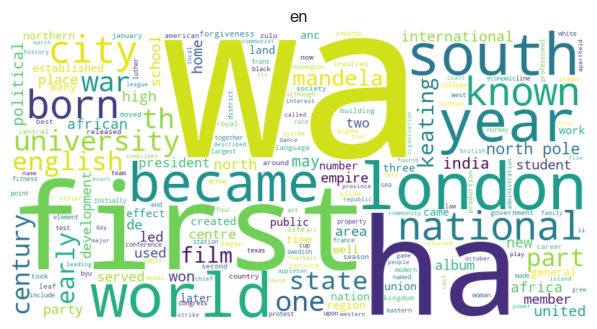

In [1049]:
#nube de palabras en ingles


#separando los datos para facilitarnos la creacion de las graficas
groups = textFinal.groupby(textFinal.Language)
textFinalEn = groups.get_group("en")
textFinalNl = groups.get_group("nl")

# Nube de palabras en ingles
# Import the required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert float items to strings in the palabras list
palabras_por_categoria = textFinalEn.groupby('Language')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordcloudsEn = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordcloudsEn[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordcloudsEn.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

en el anterior grafico tenemos un primer acercamiento con las palabras mas repetidas del idioma ingles, sin embargo, aunque es bastante grafica y llamativa, nos presenta la informacion de una manera poco precisa, por tanto continuaremos desarrollando diagramas que nos permitan apreciar de mejor manera las caracteristicas del conjunto.

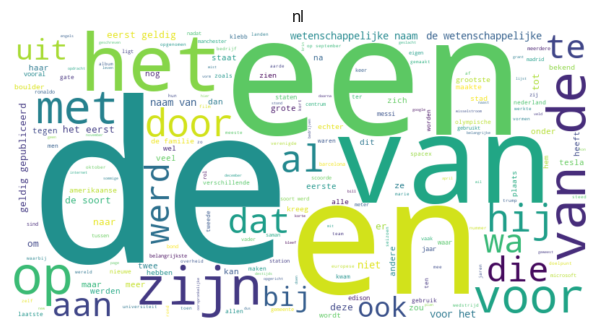

In [1050]:
#nube de palabras en holandes


# Nube de palabras en holandes
# Import the required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert float items to strings in the palabras list
palabras_por_categoria = textFinalNl.groupby('Language')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordcloudsEn = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordcloudsEn[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordcloudsEn.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

en el anterior grafico tenemos un primer acercamiento con las palabras mas repetidas del idioma Holandes, sin embargo, aunque es bastante grafica y llamativa, nos presenta la informacion de una manera poco precisa, por tanto continuaremos desarrollando diagramas que nos permitan apreciar de mejor manera las caracteristicas del conjunto.

cantidad total de palabras:

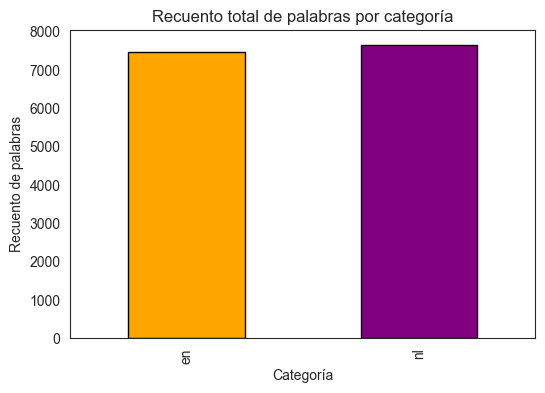

--------------------------
Palabras totales por categoría 👇
--------------------------


Language
en    7474
nl    7653
Name: token, dtype: int64

In [1051]:
word_count = textFinal.groupby('Language')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['orange', 'purple']  # Colores para las categorías 'ingles' y 'holandes'
word_count.plot(kind='bar', ax=ax, color=colors, edgecolor = 'black', linewidth = 1)
ax.set_xlabel('Categoría')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por categoría')

# Mostrar la tabla gráfica
plt.show()

print('--------------------------')
print('Palabras totales por categoría 👇')
print('--------------------------')
textFinal.groupby(by='Language')['token'].count()

esta resulta ser una de las metricas mas importantes del conjunto, debido a que nos permite saber si el conjunto esta desbalanciado, cosa que como podemos apreciar, no ocurre en este caso.

Cantidad de palabras distintas:

In [1052]:
print('----------------------------')
print('Palabras distintas por categoria 👇')
print('----------------------------')
textFinal.groupby(by='Language')['token'].nunique()

----------------------------
Palabras distintas por categoria 👇
----------------------------


Language
en    2626
nl    2631
Name: token, dtype: int64

porcentaje de palabras distintas:

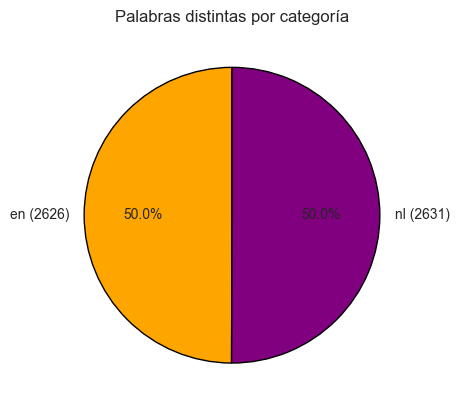

In [1053]:
unique_words = textFinal.groupby('Language')['token'].nunique()


# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors,wedgeprops = {"linewidth": 1, "edgecolor": "black"})

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por categoría')

# Mostrar el gráfico de pastel
plt.show()

podemos ver graficamente que la mitad de las palabras unicas de un idioma son de ingles y la otra mitad son de holandes.

palabras comunes entre categorias:

In [1054]:
palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])


print(f"Palabras comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras comunes entre Ingles y Holandes: 164


nube de palabras comunes Ingles y Holandes:

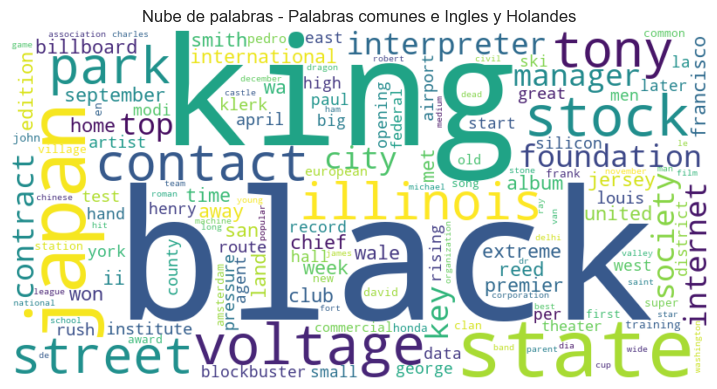

In [1055]:
palabras_comunes = palabrasEn.intersection(palabrasNl)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)

# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes e Ingles y Holandes')
plt.show()

en el anterior grafico tenemos un primer acercamiento con las palabras mas repetidas en ambos idiomas, sin embargo, aunque es bastante grafica y llamativa, nos presenta la informacion de una manera poco precisa, por tanto continuaremos desarrollando diagramas que nos permitan apreciar de mejor manera las caracteristicas del conjunto.

Segunda prueba:
es bien sabido que las palabras repetidas en ambos idiomas representan un problema a la hora de determinar el idioma ya que estas estan compuestas de nombres propios y palabras con diferente significado e igual escritura, ademas de pertenecer a cualquiera de los dos conjuntos de datos, afectando asi la prediccion de la oracion en cuestion.
por tanto nos enfrentamos a una dificil decicion, la cual podemos afrontar a partir de dos politicas.
* primera politica seria no eliminar las palabras repetidas debido a que esto reduciria el conjuto de datos sobre el cual trabajamos, sin embargo podria representar una precicion menor.
* segunda politica seria eliminar las palabras repetidas debido a que estas no poseen ningun valor a la hora de determinar el lenguaje de la palabra, aumentando de esta manera la precicion del modelo.
para dar solucion a dicho problema decidimos evaluar ambas politicas al entrenar y probar un modelo con las mismas variables y una entrada de texto diferente (con palabras repetidas y sin palabras repetidas).

contando la cantidad de palabras repetidas:

In [1056]:
pruebas = pd.DataFrame()
pruebas = df.copy()
pruebas["texto_tokenizado"]=df.apply(lambda x: to_array(x), axis=1)
textFinal = textFinal.drop(columns='token')
textFinal = pruebas.explode(column='texto_tokenizado')
textFinal = textFinal.rename(columns={'texto_tokenizado': 'token'})


palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])

print(f"Palabras en Ingles: {len(palabrasEn)}, Palabras en Holandes: {len(palabrasEn)}, comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras en Ingles: 2626, Palabras en Holandes: 2626, comunes entre Ingles y Holandes: 164


definiendo la funcion de eliminacion de palabras repetidas:

In [1057]:
def eliminar_comunes(palabras):
    token=palabras[2]
    respuesta  = set(token)
    respuesta.difference_update(palabras_comunes)
    respuesta = list(respuesta)
    return respuesta
    

creando el conjunto sin palabras repetidas:

In [1058]:
dfCopy["texto_tokenizado"]=pruebas.apply(
    lambda x: eliminar_comunes(x), axis=1)
textFinalCopy["token"]=dfCopy["texto_tokenizado"]
dfCopy.to_csv(
    'resultadoTokenizCopy.csv', index=False)

In [1059]:
ruta_archivo = r'./resultadotokenizCopy.csv'

# Leer el archivo CSV
dfCopy = pd.read_csv(ruta_archivo, nrows=100000)

contando la cantidad de palabras repetidas:

In [1060]:
pruebas = dfCopy.copy()
pruebas["texto_tokenizado"]=dfCopy.apply(lambda x: to_array(x), axis=1)
textFinalCopy = textFinalCopy.drop(columns='token')
textFinalCopy = pruebas.explode(column='texto_tokenizado')
textFinalCopy = textFinalCopy.rename(columns={'texto_tokenizado': 'token'})


palabrasEn = set(textFinalCopy[textFinalCopy.Language == 'en']['token'])
palabrasNl = set(textFinalCopy[textFinalCopy.Language == 'nl']['token'])
print(f"Palabras en Ingles: {len(palabrasEn)}, Palabras en Holandes: {len(palabrasEn)}, comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras en Ingles: 2462, Palabras en Holandes: 2462, comunes entre Ingles y Holandes: 0


a continuacion se evaluara el modelo con ambas politicas, y de esta manera se determinara con cual conjunto de datos trabajaremos a continuacion.

In [1061]:
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)
datos_XCopy = dfCopy['texto_tokenizado']
datos_yCopy = dfCopy['Language']

print(datos_XCopy.unique())
print(datos_yCopy.unique())

X_trainCopy, X_testCopy, y_trainCopy, y_testCopy = train_test_split(
    datos_XCopy,
    datos_yCopy,
    test_size=0.80,
    random_state=42
)# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
vectorizer = CountVectorizer()


# Ajustar el vectorizador con los datos de entrenamiento del conjunto con stopwords
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

# Ajustar el vectorizador con los datos de entrenamiento del conjunto sin stopwords
XtrainCopy = vectorizer.fit_transform(X_trainCopy)

# Transformar los datos de prueba utilizando el vectorizador ajustado
XtestCopy = vectorizer.transform(X_testCopy)

def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices

xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
xtrainCopy, xtestCopy, selected_feature_indicesCopy=cuasiConstantes(XtrainCopy, XtestCopy)

["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']
["['to', 'africa', 'year', 'winner', 'match', 'after', 'south', 'permission']"
 "['africa', 'president', 'match', 'tournament', 'were', 'resumption', 'series', 'wearing', 'present

In [1062]:
rf_Model = RandomForestClassifier()
def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid
aram_grid = {'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
rf_Grid1 = RandomForestFit(xtrain,y_train,param_grid)
rf_Grid2 = RandomForestFit(xtrainCopy,y_trainCopy,param_grid)

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba con palabras repetidas
print("Prueba de la primera politica:")
train_accuracy = rf_Grid1.score(xtrain, y_train) * 100
test_accuracy = rf_Grid1.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba sin palabras repetidas
print("Prueba de la segunda politica:")
train_accuracyCopy = rf_Grid2.score(xtrainCopy, y_trainCopy) * 100
test_accuracyCopy = rf_Grid2.score(xtestCopy, y_testCopy) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracyCopy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracyCopy))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Prueba de la primera politica:
Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.363%
Prueba de la segunda politica:
Precisión del entrenamiento: 96.714%
Precisión de prueba: 96.140%


podemos ver que la politica con mejor resultado es la de no eliminar las palabras repetidas, por tanto continuaremos trabajando con el conjunto de datos sin palabras repetidas.

Funcion de importancia de una palabra:
Se calcula el log odds ratio de cada palabra en el texto y determina si una palabra es más frecuente en la categoría ingles o holandes, para ello utilizaremos la funcion que se puede apreciar a continuacion.

![image.png](attachment:image.png)

los valores de la formula se representan de la siguiente manera:

* nk el número de veces que aparece el término k en los textos de cada categoria y N el número total de términos de cada usuario.
* rotte & fresh: La probabilidad estimada de que la palabra aparezca en la categoría ingles o holandes
* log_odds: El logaritmo de la razón de probabilidades (log odds ratio) de la palabra entre las categorías "ingles" y "holandes".
* abs_log_odds: Este valor representa la magnitud de la diferencia en la probabilidad de la palabra entre las categorías.
* categoria frecuente: La categoría en la que la palabra es más frecuente según el log odds ratio. "ingles" indica que la palabra es más frecuente en la categoría "ingles", y "holandes" indica que es más frecuente en la categoría "holandes".

Los valores positivos indican una asociación más fuerte con la categoría "holandes", mientras que los valores negativos indican una asociación más fuerte con la categoría "ingles".

calculo de la probabilidad de cada palabra

In [1063]:
# Cálculo del log of odds ratio de cada palabra (en vs nl)

# Pivotaje y despivotaje
comentarios_pivot = textFinal.groupby(["Language","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="Language", values= "count")

comentarios_pivot = comentarios_pivot.fillna(value=0)
comentarios_pivot.columns.name = None

comentarios_unpivot = comentarios_pivot.melt(value_name='n', var_name='Language', ignore_index=False)
comentarios_unpivot = comentarios_unpivot.reset_index()

# Selección de las categorias en y nl
comentarios_unpivot = comentarios_unpivot[comentarios_unpivot.Language.isin(['en', 'nl'])]

# Se añade el total de palabras de cada categoria
comentarios_unpivot = comentarios_unpivot.merge(
                    textFinal.groupby('Language')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'Language'
                 )

# Cálculo de odds y log of odds de cada palabra
comentarios_logOdds = comentarios_unpivot.copy()
comentarios_logOdds['odds'] = (comentarios_logOdds.n + 1) / (comentarios_logOdds.N + 1)
comentarios_logOdds = comentarios_logOdds[['token', 'Language', 'odds']] \
                    .pivot(index='token', columns='Language', values='odds')
comentarios_logOdds.columns.name = None

comentarios_logOdds['log_odds']     = np.log(comentarios_logOdds.en/comentarios_logOdds.nl)
comentarios_logOdds['abs_log_odds'] = np.abs(comentarios_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de en. Esto es así porque el ratio se ha
# calculado como en/nl.

comentarios_logOdds['categoria frecuente'] = np.where(comentarios_logOdds.log_odds > 0,
                                              "nl",
                                              "en"
                                    )

top 15 palabras mas representativas:

In [1064]:
print('-----------------------------------')
print('Top 15 palabras más diferenciadoras 👇')
print('-----------------------------------')
comentarios_logOdds.sort_values('abs_log_odds', ascending=False).head(15)

-----------------------------------
Top 15 palabras más diferenciadoras 👇
-----------------------------------


,en,nl,log_odds,abs_log_odds,categoria frecuente
token,,,,,
het,0.000134,0.031487,-5.461133,5.461133,en
een,0.000134,0.028482,-5.360831,5.360831,en
van,0.000268,0.040240,-5.013288,5.013288,en
to,0.018462,0.000131,4.950918,4.950918,nl
voor,0.000134,0.013457,-4.611065,4.611065,en
en,0.000268,0.026653,-4.601309,4.601309,en
op,0.000134,0.012412,-4.530213,4.530213,en
zijn,0.000134,0.012020,-4.498124,4.498124,en
and,0.035184,0.000392,4.497206,4.497206,nl


en la tabla anterior se puede apreciar mucha informacion reelevante a partir de la importancia de la palabra en ambos idiomas, si bien no es muy grafica o muy vistosa, permite estudiar de mejor manera el comportamiento de dichas palabras al presentar una mayor cantidad de datos que otras representaciones graficas.

Text(0.5, 0, 'log odds ratio (ingles / holandes)')

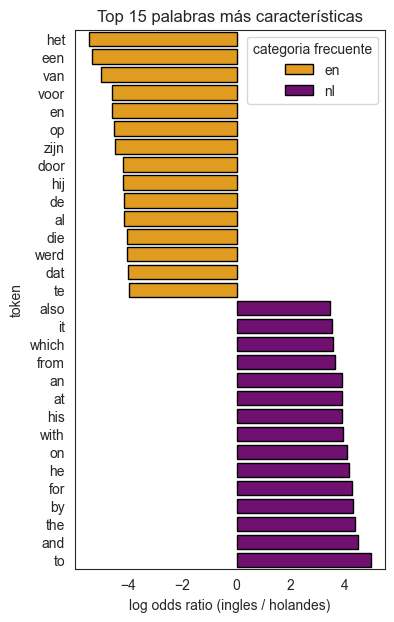

In [1065]:
top_30 = comentarios_logOdds[['log_odds', 'abs_log_odds', 'categoria frecuente']] \
        .groupby('categoria frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.set_style(style="white",rc= {'patch.edgecolor': 'black'})
sns.barplot(
    x='log_odds',
    y='token',
    hue='categoria frecuente',
    data=top_30,
    ax=ax,
    palette=["orange","purple"]
)
ax.set_title('Top 15 palabras más características')
ax.set_xlabel('log odds ratio (ingles / holandes)')

El grafico anterior nos permite apreciar de manera mas grafica las palabras con mayor peso en ambos idiomas.

Frecuencia de las palabras:
Otro valor importante ademas del peso de la palabra en ambos lenguajes, es la precuencia de cada termino, podremos calcular la frecuencia de cada término en el texto mediante el cálculo del Term Frequency (tf) y Inverse Document Frequenci (idf).

* tf: frecuencia relativa de cada termino.
* idf: es util para calcular la importancia relativa de cada término

Calculando tf:

In [1066]:
tf = textFinal.copy()
# Número de veces que aparece cada término en cada comentario
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por comentario
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(10)

,token,count,total_count,tf
0,a1a1aa,1,1,1.0
3398,plating,1,1,1.0
3397,plateau,1,1,1.0
3396,plate,1,1,1.0
3395,plastic,2,2,1.0
3394,planning,2,2,1.0
3393,plannen,2,2,1.0
3392,planeet,1,1,1.0
3391,plan,4,4,1.0
3390,plain,1,1,1.0


En la tabla anterior, se puede apreciar la frecuencia relativa de cada uno de los terminos.

Calculando idf:

In [1067]:
idf = textFinal.copy()
total_documents = idf["token"].drop_duplicates().count()
# Número de comentarios en los que aparece cada término
idf = idf.groupby(["token"])["token"].agg(["count"]).reset_index()
idf[' n_comentarios'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf[' n_comentarios'])
idf = idf[["token"," n_comentarios", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_comentarios,idf
4355,the,622,2.102682
1040,de,597,2.143705
2109,in,506,2.309086


En esta tabla podemos observa el número de Inverse Document Frequency ademas del número de comentarios en los que aparece cada término.

apartir de este punto realizaremos el calculo de la importancia de cada una de las palabras guardando el indicador en la columna "tf_idf" del dataframe tf_idf y apoyandonos en los valores de tf e idf, de la siguiente manera:

tf * idf

esto nos permitira identificar los términos más relevantes y distintivos en un conjunto de documentos.

calculando tf_idf:

In [1068]:
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="token").head()

,token,count,total_count,tf,n_comentarios,idf,tf_idf
0,a1a1aa,1,1,1.0,1,8.535622,8.535622
1,aa,1,1,1.0,1,8.535622,8.535622
2,aaaa,1,1,1.0,1,8.535622,8.535622
3,aaaaaa,1,1,1.0,1,8.535622,8.535622
4,aabel,1,1,1.0,1,8.535622,8.535622


Creando el conjunto de datos final:

In [1069]:
# Acceder a los datos de las columnas
Language = df['Language']
Text = df['Text']
texto_tokenizado = df['texto_tokenizado']

df.head()

,Language,Text,texto_tokenizado
0,en,"and Africa in permission winners,[25] of in ye...","['and', 'africa', 'in', 'permission', 'winner'..."
1,en,President tournament wearing presenting were m...,"['president', 'tournament', 'wearing', 'presen..."
2,en,The the are 'The thirty-eight reference as Ell...,"['the', 'the', 'are', 'the', 'reference', 'ell..."
3,en,a The Rugby In and Warrant head 'The Webb and ...,"['the', 'rugby', 'in', 'and', 'warrant', 'head..."
4,en,an high - The game engraved Crown Football two...,"['an', 'high', 'the', 'game', 'engraved', 'cro..."


A continuacion crearemos los conjuntos de prueba y entrenamiento, apoyandonos en la funcion train_test_split, dicha funcion recibe los siguientes parametros:

* arrays: Las entradas permitidas son listas, matrices numpy, matrices scipy-sparse o marcos de datos pandas.
* test_size: Si es flotante, debe estar entre 0,0 y 1,0 y representar la proporción del conjunto de datos que se incluirá en la división de prueba. Si es int, representa el número absoluto de muestras de prueba. Si es Ninguno, el valor se establece en el complemento del tamaño del tren. Si train_sizetambién es Ninguno, se establecerá en 0,25.
* random_state: Controla la mezcla aplicada a los datos antes de aplicar la división. Pase un int para obtener una salida reproducible en múltiples llamadas a funciones. 

In [1070]:
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)

["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']


Vectorizamos los datos:

In [1071]:
# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

print(Xtrain.shape)

tokens = vectorizer.get_feature_names_out()
print("Tokens:", tokens)

print("Tokens:", len(tokens))

print("Conjunto de entrenamiento - Características:", Xtrain.shape)
print("Conjunto de entrenamiento - Etiquetas:", y_train.shape)
print("Conjunto de prueba - Características:", Xtest.shape)
print("Conjunto de prueba - Etiquetas:", y_test.shape)

(213, 1492)
Tokens: ['aan' 'aandelen' 'aangrenzende' ... 'zwart' 'zwelethini' 'zwitserse']
Tokens: 1492
Conjunto de entrenamiento - Características: (213, 1492)
Conjunto de entrenamiento - Etiquetas: (213,)
Conjunto de prueba - Características: (855, 1492)
Conjunto de prueba - Etiquetas: (855,)


Seleccion de caracteristicas:
La Selección de Características es el proceso de seleccionar las más importante y/o relevante características de un conjunto de datos, con el objetivo de mejorar el rendimiento de predicción de los predictores, proporcionar predictores más rápidos y más rentables y proporcionar una mejor comprensión del proceso subyacente que generó los datos.
la aplicacion de estos metodos busca reducir el número de características basadas en filtros para obtener así subconjuntos de características.
en este trabajo utilizaremos dos de estos metodos para generar diferentes conjuntos de datos, dichos conjuntos de datos son:

* Cuasi-Constantes.
* Seleccion de Caracteristicas Random (RFE).

Seleccion de caracteristicas Cuasi-Constantes:
este selector de caracteristicas es parte de un conjunto de metodos de seleccion de caracteristicas llamados Métodos de filtro, los cuales funcionan de la siguiente manera:

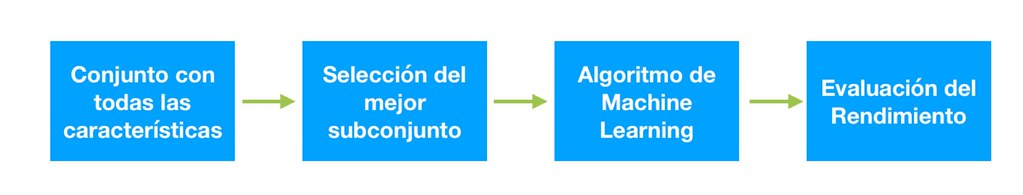

Los métodos de filtro se utilizan generalmente como un paso de preprocesamiento de datos y la selección de características por filtro es independiente de cualquier algoritmo de Machine Learning.

Las características se clasifican según los puntajes estadísticos que tienden a determinar la correlación de las características (en este caso con respecto a la variable x), tenga en cuenta que la correlación es un término cuya interpretacion varia dependiendo del trabajo.  

tambien necesario saber que los métodos de filtro no eliminan la multicolinealidad, por lo tanto se debe lidiar con ellos también antes de entrenar modelos para los datos.

en nuestro modelo seleccionaremos una serie de caracteristicas basandonos en la varianza de los resultados con respecto a la media de valores de la variable x en este caso representada por la columna "text_tokenizado" del dataframe df, eliminando valores que esten fuera de dicha media de valores, lo que se podria traducir como **la eliminacion de los valores de la columna "text_tokenizado" que cuenten con menos cantidad de palabras comunes**.

accederemos a este concepto por medio de la funcion:

* VarianceThreshold (eliminando los valores que tengan una varianza mayor a **0.02** con respecto a la media)

*debido a nuestra implementacion de la funcion de seleccion de caracteristicas Cuasi-Constantes y la forma en la que esta opera (trabajando en los datos de la variable x y eliminando los valores con una varianza fuerade la media), este metodo de seleccion tambien puede ser aplicado a implementaciones de trabajo no supervisado.*

posteriormente seleccionamos las caracteristicas en base a VarianceThreshold y utilizando la funcion fit_transform la cual nos retornara un conjunto nuevo con las nuevas caracteristicas seleccionadas.

In [1072]:
def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices

xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)

Número de características seleccionadas: 79


Seleccion de caracteristicas random (RFE):
este selector de caracteristicas es parte de un conjunto de metodos de seleccion de caracteristicas llamados Métodos de envoltura, los cuales funcionan de la siguiente manera:

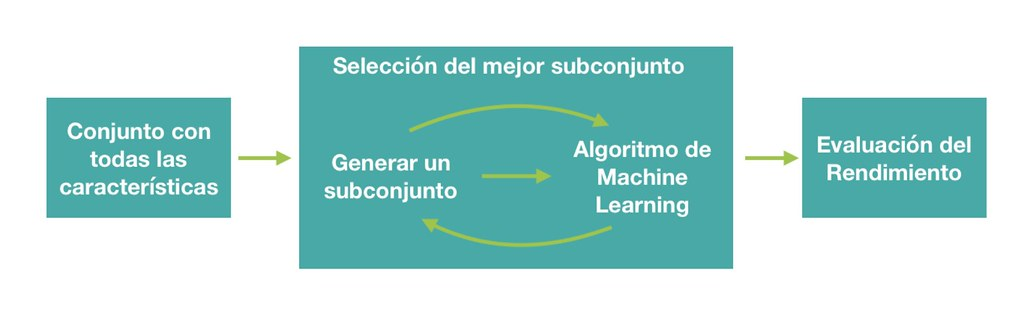

Como puedes observar, un método de envoltura necesita un algoritmo de Machine Learning y utiliza su rendimiento como criterio de evaluación. Este método busca una característica que sea más adecuada para el algoritmo y tiene como objetivo mejorar el rendimiento.

Por lo tanto, tratamos de usar un subconjunto de características y entrenamos un modelo usándolos, basándonos en las inferencias que extraemos del modelo anterior, decidimos agregar o eliminar características de su subconjunto. El problema se reduce esencialmente a un problema de búsqueda. 

sin embargo es necesario tener en cuenta que estos métodos suelen ser computacionalmente muy caros.

en nuestro modelo seleccionaremos una serie de caracteristicas basandonos en RFE y apoyandonos en un clasificador de caracteristicas Random Forest.

* Random Forest: Un bosque aleatorio es un metaestimador que ajusta una serie de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza promedios para mejorar la precisión predictiva y controlar el sobreajuste.
* Eliminación de características recursivas (RFE): es un algoritmo de optimización que busca encontrar el subconjunto de funciones con mejor rendimiento. Crea repetidamente modelos y deja de lado la mejor o la peor característica de rendimiento en cada iteración. Construye el siguiente modelo con las características de la izquierda hasta que se agotan todas las características, luego clasifica las características según el orden de su eliminación.

accederemos a ambos conceptos por medio de las funciones:

* RandomForestClassifier.
* RFE.

para posteriormente seleccionar las caracteristicas en base a estos y utilizando la funcion fit_transform la cual nos retornara un nuevo conjunto con las nuevas caracteristicas seleccionadas.

In [1073]:

def ScaracteristicasRandom(xtrain, y_train, n_estimators=100, max_depth=None, min_samples_split=2):
    # Crear un estimador Random Forest con parámetros ajustados
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1)

    # Crear un selector RFE con Random Forest y ranking
    rfe = RFE(estimator=rf, step=2)

    # Aplicar RFE al conjunto de datos
    xtrainE = rfe.fit_transform(xtrain, y_train)
    # Obtener las características seleccionadas
    selected_features = rfe.support_
    num_selected_features = sum(selected_features)
    print("Número de características seleccionadas:", num_selected_features)

    # Obtener el ranking de importancia de características
    feature_ranking = rfe.ranking_
    # Imprimir las características seleccionadas
        

    return xtrainE, selected_features, feature_ranking

xtrainE, selected_features, feature_ranking = ScaracteristicasRandom(xtrain, y_train)
# Conjunto de prueba transformado
xtestE = xtest[:, selected_features]  

Número de características seleccionadas: 39


## Seleccionar el o los modelos.
en la siguiente seccion de la investigacion seleccionaremos los modelos a utilizar en el resto del trabajo, sin embargo, debido a que se trata de un trabajo academico con el objetivo de evaluar la implementacion de una serie de metodos en especificos, evaluaremos el rendimiento de los siguientes modelos:

* Random Forest.
* Árboles de decisión.
* Redes neuronales.
* Redes neuronales profundas (Bonus).

si bien el trabajo consiste en implementar los 3 primeros modelos, decidimos implementar un cuarto metodo con el objetivo de permitirnos conocer mas acerca de los modelos estudiados y realizar una investigacion adicional que nos permita aumentar la precicion del modelo a seleccionar, para dar solucion a la pregunta anteriormente planteada.

## Ajustar y evaluar los modelos.
A patir de de este punto se dara inicio a la implementacion y analisis detallado de los modelos mencionados con anterioridad🤖.

Árboles de decisión 🌳

creando instancia de arbol de desicion:

In [1074]:
rf_Model = DecisionTreeClassifier()

creando funcion de entrenamiento arbol de desicion:

In [1075]:
def DecisionTreeFit(x,y,params):
    rf_Grid = GridSearchCV(
        estimator = rf_Model, 
        param_grid = params,
        refit=True,
        n_jobs=-1,
        cv=5,
    )
    rf_Grid.fit(x, y)
    return rf_Grid

Pruebas con parámetros por defecto y seleccion de caracteristicas Cuasi-Constantes:

estableciendo parametros (por defecto):

In [1076]:
param_grid = {
    'criterion': ['gini'],
    "splitter":["best"],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None]
}
print(param_grid)

{'criterion': ['gini'], 'splitter': ['best'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': [None]}


Descripción de los parámetros:

* criterion: La función para medir la calidad de una división. Los criterios admitidos son "gini" para la impureza de Gini y "log_loss" y "entropía", ambos para la ganancia de información de Shannon; consulte Formulación matemática . Nota: Este parámetro es específico del árbol.
* splitter:La estrategia utilizada para elegir la división en cada nodo. Las estrategias admitidas son "mejores" para elegir la mejor división y "aleatorias" para elegir la mejor división aleatoria.
* max_depth: La profundidad máxima del árbol.
* min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
* min_samples_leaf: El número mínimo de muestras necesarias para estar en un nodo de hoja.
* max_features: La cantidad de características a considerar al buscar la mejor división, la búsqueda de una división no se detiene hasta que se encuentra al menos una partición válida de las muestras de nodos.

entrenando:

In [1077]:
rf_Grid = DecisionTreeFit(xtrain,y_train,param_grid)

analizando resultados:

In [1078]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [1079]:
rf_Grid.best_score_

0.953045404208195

In [1080]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.95      0.98      0.97       428
          nl       0.98      0.95      0.97       427

    accuracy                           0.97       855
   macro avg       0.97      0.97      0.97       855
weighted avg       0.97      0.97      0.97       855



In [1081]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 96.725%


Prueba con Hiperparámetros y seleccion de caracteristicas Cuasi-Constantes:

estableciendo parametros:

In [1082]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    "splitter":["best", "random"],
    'max_depth': [int(x) for x in np.linspace(start=50, stop=300, num=6)]+[None],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=10, num=5)]+[None],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=15, num=14)]+[None],
    'max_features': [int(x) for x in np.linspace(start=1, stop=10, num=10)]
}
print(param_grid)

{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [50, 100, 150, 200, 250, 300, None], 'min_samples_split': [2, 4, 6, 8, 10, None], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


entrenando:

In [1083]:
rf_Grid = DecisionTreeFit(xtrain,y_train,param_grid)

analizando resultados:

In [1084]:
rf_Grid.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'splitter': 'best'}

In [1085]:
rf_Grid.best_score_

0.9906976744186047

In [1086]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.93      1.00      0.96       105
          nl       1.00      0.93      0.96       108

    accuracy                           0.96       213
   macro avg       0.96      0.96      0.96       213
weighted avg       0.97      0.96      0.96       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.92      0.99      0.96       428
          nl       0.99      0.91      0.95       427

    accuracy                           0.95       855
   macro avg       0.96      0.95      0.95       855
weighted avg       0.96      0.95      0.95       855



In [1087]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 96.244%
Precisión de prueba: 95.322%


Prueba con Hiperparametros y seleccion de caracteristicas Random (RFE):

estableciendo parametros:

In [1088]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    "splitter":["best", "random"],
    'max_depth': [int(x) for x in np.linspace(start=50, stop=300, num=6)]+[None],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=10, num=5)]+[None],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=15, num=14)]+[None],
    'max_features': [int(x) for x in np.linspace(start=1, stop=10, num=10)]
}
print(param_grid)

{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [50, 100, 150, 200, 250, 300, None], 'min_samples_split': [2, 4, 6, 8, 10, None], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


entrenando:

In [1089]:
rf_Grid = DecisionTreeFit(xtrainE,y_train,param_grid)

analizando resultados:

In [1090]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'splitter': 'best'}

In [1091]:
rf_Grid.best_score_

0.9906976744186047

In [1092]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
y_pred_train = rf_Grid.predict(xtrainE)
y_pred_test  = rf_Grid.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.98      1.00      0.99       105
          nl       1.00      0.98      0.99       108

    accuracy                           0.99       213
   macro avg       0.99      0.99      0.99       213
weighted avg       0.99      0.99      0.99       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.97      0.99      0.98       428
          nl       0.99      0.96      0.98       427

    accuracy                           0.98       855
   macro avg       0.98      0.98      0.98       855
weighted avg       0.98      0.98      0.98       855



In [1093]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.061%
Precisión de prueba: 97.544%


a partir de la ejecucion de las pruebas en los modelos, podemos ver los siguiente resultados:

* Resultados de prueba con parametros por defecto y selecccion de caracteristicas Cuasi-Constantes:
    1. presicion en datos de entrenamiento: 100% 
    2. presicion en datos de prueba: 97.544%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas Cuasi-Constantes:
    1. presicion en datos de entrenamiento: 95.775%
    2. presicion en datos de prueba: 93.450%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas random(RFE):
    1. presicion en datos de entrenamiento: 97.653%
    2. presicion en datos de prueba: 94.737%

interpretando estos resultados, podemos ver que a pesar de que la configuracion de variables mas optima es la de la prueba por de fecto, el conjunto de prueba mas preciso es el de caracteristicas random (RFE), por tanto, realizaremos las siguientes pruebas:

* prueba con parametros por defecto y seleccion de caracteristicas random (RFE).
* prueba con parametros por defecto modificando las caracteristicas que segun el selector de caracteristicas GridSearchCV y bajo mi propio criterio dieron mejores resultados en la segunda prueba y seleccion de caracteristicas random (RFE).
* prueba con parametros por defecto modificando las caracteristicas que segun el selector de caracteristicas GridSearchCV y bajo mi propio criterio dieron mejores resultados en la segunda prueba y seleccion de caracteristicas random (RFE).

pruebas de ajuste:

A continuación se realizan tres pruebas con diferentes hiperparámetros con el objetivo de perfeccionar el modelo a partir de las configuraciones y resultados obtenidos en las pruebas anteriores.

estableciendo los parametros de los modelos:

In [1094]:
param_sets = [
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtestE,
            "y":y_test
        },
        "params":{
            'criterion': ['gini'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': [None]
        }
    },
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtestE,
            "y":y_test
        },
        "params":{
            'criterion': ['gini'],
            'max_depth': [None],
            'max_features': [9],
            'min_samples_leaf':[1],
            'min_samples_split': [2],
            'splitter': ['best']
        }
    },
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtestE,
            "y":y_test
        },
        "params":{
            'criterion': ['gini'],
            'max_depth': [None],
            'max_features': [9],
            'min_samples_leaf': [1],
            'min_samples_split': [2],
            'splitter': ['random']
        }
    },
]

ejecutando el modelo:

In [1095]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo TreeDecisionClassifier
    rf_Grid = DecisionTreeFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Número de prueba:  1
Parámetros:  {'criterion': ['gini'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': [None]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  96.84%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tiempo de ejecución :  0.04 segundos
--------------------------------------
Número de prueba:  2
Parámetros:  {'criterion': ['gini'], 'max_depth': [None], 'max_features': [9], 'min_samples_leaf': [1], 'min_samples_split': [2], 'splitter': ['best']}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  98.01%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Tiempo de ejecución :  0.03 segundos
--------------------------------------
Número de prueba:  3
Parámetros:  {'criterion': ['gini'], 'max_depth': [None], 'max_features': [9], 'min_sampl

Conclusion:
a partir de las pruebas realizadas, podemos determinar que la mejor configuracion para el modelo de inteligencia artificial, arbol de desicion es:

{
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None]
}

tambien conocida como la configuracion por defecto, implementada en conjunto con el selector de caracteristicas random (RFE), sin embargo, esta configuracion tiene todavia campo para mejoras, permitiendonos aumentar la precision del modelo, mas especificamente en la particion de prueba, debido a que a diferencia de las pruebas en el conjunto de entrenamiento, estas presentan un porcentaje de precicion menor.
algunas de las estrategias que podriamos implementar para aumentar la precision del modelo son las siguientes:

* ampliar la cantidad de datos del cojunto: esto nos premitirias realizar estimaciones aun mas precisas en los datos de prueba, debido a que el modelo se enfrentaria a una mayor cantidad de nodos del arbol, permitiendole identificar patrones mas complejos y realizar estimaciones mas precisas.
* probar diferentes selectores de caracteristicas: como pudo apreciarse en la mejoria al cambiar el selector de caracteristicas de Cuasi-Constantes a Randon(RFE), estos juegan un papel importante en el ajuste del modelo, por tanto considero que probar con una mayor cantidad de selectores de caracteristicas, podria brindarnos mejores resultados.
* probar nuevas configuraciones: si bien obtuvimos mejores resultados con las configuraciones por defecto, una vez aplicadas las politicas anteriores, podriamos darle un poco mas de precision al modelo explorando con nuevas configuraciones, especificamente en los parametros "max_depth" y "max_features".

Random Forest 🌄

creando instancia de random forest:

In [1096]:
rf_Model = RandomForestClassifier()

creando funcion de entrenamiento de bosque random:

In [1097]:
def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, refit=True, n_jobs=-1, cv=5)
    rf_Grid.fit(x, y)
    return rf_Grid

Pruebas para random forest con parámetros por defecto:

estableciendo parametros (por defecto):

In [1098]:
param_grid = {'n_estimators': [100],
               "criterion":["gini"],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
print(param_grid)

{'n_estimators': [100], 'criterion': ['gini'], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}


Descripción de parámetros:

* n_estimators: La cantidad de árboles en el bosque.
* max_features: La función para medir la calidad de una división.
* max_depth: La profundidad máxima del árbol.
* min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
* min_samples_leaf: El número mínimo de muestras necesarias para estar en un nodo de hoja.
* random_state: Controla tanto la aleatoriedad del arranque de las muestras utilizadas al construir árboles (if bootstrap=True) como el muestreo de las características a considerar al buscar la mejor división en cada nodo (if ).

entrenando:

In [1099]:
rf_Grid = RandomForestFit(xtrain,y_train,param_grid)

analizando resultados:

In [1100]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': None}

In [1101]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.830%


Prueba con Hiperparámetros y seleccion de caracteristicas Cuasi-Constantes:

estableciendo parametros:

In [1102]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=300, num=3)],
               "criterion":["gini"],
               'max_features': ["sqrt", "log2", None],
               'max_depth': [None],
               'min_samples_split': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               'min_samples_leaf': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               "random_state":[int(x) for x in np.linspace(start=20, stop=40, num=2)]       
            }
print(param_grid)      
                

{'n_estimators': [200, 250, 300], 'criterion': ['gini'], 'max_features': ['sqrt', 'log2', None], 'max_depth': [None], 'min_samples_split': [4, 6, 8, None], 'min_samples_leaf': [4, 6, 8, None], 'random_state': [20, 40]}


entrenando:

In [1103]:
rf_Grid = RandomForestFit(xtrain,y_train,param_grid)

analizando resultados:

In [1104]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200,
 'random_state': 20}

In [1105]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.531%
Precisión de prueba: 98.830%


Prueba con Hiperparametros y seleccion de caracteristicas Random (RFE):
estableciendo parametros:

In [1106]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=300, num=3)],
               "criterion":["gini"],
               'max_features': ["sqrt", "log2", None],
               'max_depth': [None],
               'min_samples_split': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               'min_samples_leaf': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               "random_state":[int(x) for x in np.linspace(start=20, stop=40, num=2)]       
            }

print(param_grid)

{'n_estimators': [200, 250, 300], 'criterion': ['gini'], 'max_features': ['sqrt', 'log2', None], 'max_depth': [None], 'min_samples_split': [4, 6, 8, None], 'min_samples_leaf': [4, 6, 8, None], 'random_state': [20, 40]}


entrenando:

In [1107]:
rf_Grid = RandomForestFit(xtrainE,y_train,param_grid)

analizando resultados:

In [1108]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200,
 'random_state': 20}

In [1109]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.531%
Precisión de prueba: 98.246%


a partir de la ejecucion de las pruebas en los modelos, podemos ver los siguiente resultados:

* Resultados de prueba con parametros por defecto y selecccion de caracteristicas Cuasi-Constantes:
    1. precision en datos de entrenamiento: 100% 
    2. precision en datos de prueba: 99.181%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas Cuasi-Constantes:
    1. precision en datos de entrenamiento: 99.531%
    2. precision en datos de prueba: 98.830%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas random(RFE):
    1. precision en datos de entrenamiento: 99.531%
    2. precision en datos de prueba: 98.012%

interpretando estos resultados, podemos ver que la configuracion de variables mas optima es la de la prueba por de fecto y el conjunto de prueba mas preciso es el de caracteristicas Cuasi-Constantes por muy poco, por tanto, realizaremos las siguientes pruebas:

* prueba con parametros por defecto modificando las caracteristicas que bajo mi criterio podrian optimizar el modelo y seleccion de caracteristicas Cuasi-Constantes.
* prueba con parametros por defecto modificando las caracteristicas que segun el selector de caracteristicas GridSearchCV y bajo mi criterio dieron mejores resultados en la segunda prueba y seleccion de caracteristicas Cuasi-Constantes.
* prueba con parametros por defecto modificando las caracteristicas que segun el selector de caracteristicas GridSearchCV y bajo mi criterio dieron mejores resultados en la segunda prueba y seleccion de caracteristicas Cuasi-Constantes.

pruebas de ajuste:

A continuación se realizan tres pruebas con diferentes hiperparámetros con el objetivo de perfeccionar el modelo a partir de las configuraciones y resultados obtenidos en las pruebas anteriores.

estableciendo los parametros de los modelos:

In [1110]:
param_sets = [
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'n_estimators': [100],
            "criterion":["gini"],
            'max_features': ['sqrt'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [2],
            "random_state":[20]       
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'n_estimators': [100],
            "criterion":["gini"],
            'max_features': ['log2'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            "random_state":[None]       
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'n_estimators': [200],
            "criterion":["gini"],
            'max_features': ['log2'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            "random_state":[None]       
        }
    },
]


ejecutando los modelos:

In [1111]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo RandomForestClassifier
    rf_Grid = RandomForestFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Número de prueba:  1
Parámetros:  {'n_estimators': [100], 'criterion': ['gini'], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [2], 'random_state': [20]}
Precisión de entrenamiento:  99.53%
Precisión de prueba:  98.71%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 20}
Tiempo de ejecución :  0.38 segundos
--------------------------------------


Número de prueba:  2
Parámetros:  {'n_estimators': [100], 'criterion': ['gini'], 'max_features': ['log2'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  98.95%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': None}
Tiempo de ejecución :  0.37 segundos
--------------------------------------
Número de prueba:  3
Parámetros:  {'n_estimators': [200], 'criterion': ['gini'], 'max_features': ['log2'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  99.30%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': None}
Tiempo de ejecución :  0.56 segund

Conclusion:
a partir de las pruebas realizadas, podemos determinar que la mejor configuracion para el modelo de inteligencia artificial, bosque random es:

{
    'n_estimators': [200],
    "criterion":["gini"],
    'max_features': ['log2'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    "random_state":[None]       
}

esta configuracion es tomada a partir de la configuracion por defecto con algunas mejoras, implementada en conjunto con el selector de caracteristicas Cuasi-Constante.
las mejorar que realizamos con respecto al modelo por defecto combinado fueron las siguientes:

* n_estimators: luego de una serie de pruebas, podemos ver que en general esta configuracion nos brinda resultados iguales o mejores que la configuracion por defecto de 100, esto debido a que al contar la estrategia de Bootstraping y una gran cantidad de arboles de desicion, puede explorar un mayor numero de opciones que en algunos casos resultan mejores que con la configuracion estandar.            no obstante, comprendemos la decision de establecer el numero de estimadores por defecto en 100 por parte del equipo de desarrollo de sklearn, debido a que aumentar el numero de estimadores aumenta tambien el tiempo de ejecucion del modelo.
* max_features: a lo largo de las pruebas pudimos apreciar que el valor para max_features que nos dio mejores resultados, fue "log2", con respecto a la configuracion por defecto "sqrt", esto quiere decir el numero de características a considerar al buscar la mejor división que escogimos para nuestro modelo fue log2(n_features) es decir el numero asociado a la funcion "log2", con respecto a las demas opciones.

otro factor importante en nuestro modelo fue la desicion de establecer el parametro criterion como "gini" en todas nuestras pruebas, motivados por los resultados obtenidos en la evaluacion del modelo anterior, debido a que ambos modelos trabajan de la mano y este parametro se aplicaria a los arboles que conforman nuestro bosque random, dicha desicion se vio reflejada en los resultados de la precision de las distintas pruebas, brindandonos porcentajes de presicion sumamente altos y cercanos al umbral del 100% de presicion tanto con los datos de entrenamiento como con los datos de prueba.

finalmente podemos concluir que nuestro modelo fue significativamente preciso y eficiente, sin embargo hay una pequeña probabilidad de mejorar todavia mas nuestro modelo al aplicar una politica, dicha politica es:

* probar diferentes selectores de caracteristicas: como pudo apreciarse en las pruebas del modelo anterior (arboles de desicion), estos juegan un papel importante en el ajuste del modelo, por tanto considero que probar con una mayor cantidad de selectores de caracteristicas, podria brindarnos mejores resultados, mas aun teniendo en cuenta que apesar que ambos modelos se fundamentan en una logica similar, la politica de seleccion de caracteristicas que nos brindo mejores resultados en nuestro modelo es diferente a la politica que nos dio mejores resultados en el modelo anterior (arboles de desicion).

tambien considero importante resaltar que aunque aumentar el parametro "n_estimators" nos ofrecio mejores resultados en nuestro modelo, seguirlo aumentando reflejaria un desajuste en el modelo, ademas de un tiempo de ejecucion significativamente mayor, debido a que en las pruebas que realizamos al establecer dicho parametro en un numero mayor que 200 nos brindaron un modelo menos preciso.

Red neuronal 🧠

creando instancia de red neuronal:

In [1112]:
rf_Model = MLPClassifier()

creando funcion de entrenamiento red neuronal:

In [1113]:
def MLPFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid

prueba con parametros por defecto.

estableciendo los parametros (por defecto):

In [1114]:
param_grid = {
    'hidden_layer_sizes': [(100)],
    "activation":["relu"],
    "solver":["adam"],
    'max_iter': [200],
}

Descripción de parámetros:

* hidden_layer_sizes: El iésimo elemento representa el número de neuronas en la iésima capa oculta.
* activation: Función de activación de la capa oculta.
* solver: El solucionador para la optimización del peso.
* max_iter: Número máximo de iteraciones. El solucionador itera hasta la convergencia o este número de iteraciones.

entrenando:

In [1115]:
rf_Grid = MLPFit(xtrain,y_train,param_grid)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


analizando resultados:

In [1116]:
rf_Grid.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': 100,
 'max_iter': 200,
 'solver': 'adam'}

In [1117]:
rf_Grid.best_score_

0.9953271028037383

In [1118]:
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       1.00      1.00      1.00       428
          nl       1.00      1.00      1.00       427

    accuracy                           1.00       855
   macro avg       1.00      1.00      1.00       855
weighted avg       1.00      1.00      1.00       855



In [1119]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.649%


Prueba con Hiperparámetros y seleccion de caracteristicas Cuasi-Constantes:
estableciendo los parametros:

In [1120]:
param_grid = {
    'hidden_layer_sizes': [(100),(200)],
    "activation":["identity","logistic", "tanh", "relu"],
    "solver":["lbfgs","sgd","adam"],
    'max_iter': [int(x) for x in np.linspace(start=100, stop=500, num=5)]
}

entrenando:

In [1121]:
rf_Grid = MLPFit(xtrain,y_train,param_grid)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


analizando resultados:

In [1122]:
rf_Grid.best_params_

{'activation': 'identity',
 'hidden_layer_sizes': 100,
 'max_iter': 100,
 'solver': 'adam'}

In [1123]:
rf_Grid.best_score_

0.9953271028037383

In [1124]:
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       1.00      1.00      1.00       428
          nl       1.00      1.00      1.00       427

    accuracy                           1.00       855
   macro avg       1.00      1.00      1.00       855
weighted avg       1.00      1.00      1.00       855



In [1125]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.766%


Prueba con Hiperparametros y seleccion de caracteristicas Random (RFE):
estableciendo los parametros:

In [1126]:
param_grid = {
    'hidden_layer_sizes': [(100),(200)],
    "activation":["identity","logistic", "tanh", "relu"],
    "solver":["lbfgs","sgd","adam"],
    'max_iter': [int(x) for x in np.linspace(start=100, stop=500, num=5)]
}

entrenando:

In [1127]:
rf_Grid = MLPFit(xtrainE,y_train,param_grid)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


analizando resultados:

In [1128]:
rf_Grid.best_params_

{'activation': 'identity',
 'hidden_layer_sizes': 100,
 'max_iter': 100,
 'solver': 'adam'}

In [1129]:
rf_Grid.best_score_

0.9953271028037383

In [1130]:
y_pred_train = rf_Grid.predict(xtrainE)
y_pred_test  = rf_Grid.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.99      1.00      0.99       428
          nl       1.00      0.99      0.99       427

    accuracy                           0.99       855
   macro avg       0.99      0.99      0.99       855
weighted avg       0.99      0.99      0.99       855



In [1131]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.415%


a partir de la ejecucion de las pruebas en los modelos, podemos ver los siguiente resultados:

* Resultados de prueba con parametros por defecto y selecccion de caracteristicas Cuasi-Constantes:
    1. precision en datos de entrenamiento: 100% 
    2. precision en datos de prueba: 99.649%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas Cuasi-Constantes:
    1. precision en datos de entrenamiento: 100%
    2. precision en datos de prueba: 99.649%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas random(RFE):
    1. precision en datos de entrenamiento: 100%
    2. precision en datos de prueba: 99.532%

interpretando estos resultados, podemos ver que las configuraciones de variables mas optimas son la de la prueba por defecto y la de la prueba con Hiperparametros, y el conjunto de prueba mas preciso es el de caracteristicas Cuasi-Constantes por muy poco, por tanto, realizaremos las siguientes pruebas:

* prueba con parametros por defecto combinados con los parametros de la prueba con Hiperparametros y seleccion de caracteristicas Cuasi-Constantes.
* prueba con parametros por defecto combinados con los parametros de la prueba con Hiperparametros y seleccion de caracteristicas Cuasi-Constantes.
* prueba con parametros establecidos bajo criterio propio a partir de la combinacion de los parametros por defecto y Hiperparametros, con una seleccion de caracteristicas Cuasi-Constantes.

pruebas de ajuste:

A continuación se realizan tres pruebas con diferentes hiperparámetros con el objetivo de perfeccionar el modelo a partir de las configuraciones y resultados obtenidos en las pruebas anteriores.

estableciendo los parametros de los modelos:

In [1132]:
param_sets = [
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'hidden_layer_sizes': [(100)],
            "activation":["relu"],
            "solver":["adam"],
            'max_iter': [200],
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'activation': ['identity'],
            'hidden_layer_sizes': [(100)],
            'max_iter': [500],
            'solver': ['adam']
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'activation': ['identity'],
            'hidden_layer_sizes': [(100,100)],
            'max_iter': [600],
            'solver': ['adam']
        }
    },
]


ejecutando los modelos:

In [1133]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo RandomForestClassifier
    rf_Grid = MLPFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Número de prueba:  1
Parámetros:  {'hidden_layer_sizes': [100], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  99.65%
mejores parametros:  {'activation': 'relu', 'hidden_layer_sizes': 100, 'max_iter': 200, 'solver': 'adam'}
Tiempo de ejecución :  0.78 segundos
--------------------------------------
Fitting 2 folds for each of 1 candidates, totalling 2 fits


Número de prueba:  2
Parámetros:  {'activation': ['identity'], 'hidden_layer_sizes': [100], 'max_iter': [500], 'solver': ['adam']}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  99.65%
mejores parametros:  {'activation': 'identity', 'hidden_layer_sizes': 100, 'max_iter': 500, 'solver': 'adam'}
Tiempo de ejecución :  0.66 segundos
--------------------------------------
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Número de prueba:  3
Parámetros:  {'activation': ['identity'], 'hidden_layer_sizes': [(100, 100)], 'max_iter': [600], 'solver': ['adam']}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  99.65%
mejores parametros:  {'activation': 'identity', 'hidden_layer_sizes': (100, 100), 'max_iter': 600, 'solver': 'adam'}
Tiempo de ejecución :  0.47 segundos
--------------------------------------


Conclusion:
a partir de las pruebas realizadas, podemos determinar que apesar de que los modelos iniciales fueron bastante precisos, los resultados de las diferentes configuraciones fueron fluctuantes, sin embargo la configuracion que nos brindo mejores resultados a nivel general fue.

{
    'activation': ['identity'],
    'hidden_layer_sizes': [(100)],
    'max_iter': [500],
    'solver': ['adam']
}

la configuracion fue tomada a partir de la configuracion por defecto combinada con la configuracion con hiperparametros con algunas mejoras, implementada en conjunto con el selector de caracteristicas Cuasi-Constante, ya que estas fueron las configuraciones que nos brindaron mejores resultados a nivel general.

las mejoras que realizamos con respecto al modelo por defecto combinado fueron las siguientes:

* activation: si bien la configuracion de la funcion de activacion por defecto para el modelo de red neuronal es "relu", la funcion que nos brindo mejores resultados fue "identity", la cual es una funcion de activación sin operación, que devuelve f(x) = x.
* max_iter: si bien la configuracion por defecto tenia un numero de iteraciones maximas de 100, obtuvimos un resultado mejor utilizando un numero de iteraciones maximas de 500, este numero representa la cantidad maxima de iteraciones que se haran, llegue o no a la convergencia, sin embargo para nuestro solucionador de problemas "adam" este determina la cantidad de epocas (cuántas veces se usará cada punto de datos).

finalmente podemos concluir que nuestro modelo fue significativamente preciso y eficiente, sin embargo los resultados de las pruebas de ajuste de parametros fueron bastante variables, teniendo una pequeña mejoria a nivel general (entre todas las pruebas que hicimos ejecutando el modelo varias veces) con la configuracion utilizada, no obstante hacemos las siguientes recomentaciones:

* explorar y probar el modelo con mayor detenimiento realizando un analisis mas exahustivo del mismo, para eliminar asi las variaciones entre los porcentajes de precicion de las diferentes pruebas.

tambien considero importante resaltar que al usar la funcion "identity" es necesario manejar con cautela la cantidad de capas, para evitar la aparicion del problema del gradiente que se desvanece, debido a que dicho problema se mitigaba utilizando la funcion de activacion "relu".

Redes neuronales profundas 🌀 (Bonus✨):

Generar datos de ejemplo para clasificación:

In [1134]:
datos_X, datos_y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

Escalar los datos:

In [1135]:
scaler = StandardScaler()
datos_X = scaler.fit_transform(datos_X)

Dividir los datos en conjuntos de entrenamiento y prueba:

In [1136]:

X_train, X_test, y_train, y_test = train_test_split(datos_X, datos_y, test_size=0.2, random_state=42)

Crear el modelo secuencia:

In [1137]:
model = Sequential()

Conjunto de parametros #1:

In [1138]:
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))  # Agregar regularización Dropout para reducir el sobreajuste
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/20


25/25 [==============================] - 1s 10ms/step - loss: 0.6532 - accuracy: 0.6225 - val_loss: 0.5319 - val_accuracy: 0.8350
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5318 - accuracy: 0.7425 - val_loss: 0.4569 - val_accuracy: 0.8500
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7775 - val_loss: 0.4185 - val_accuracy: 0.8450
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4080 - accuracy: 0.8238 - val_loss: 0.3920 - val_accuracy: 0.8600
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4037 - accuracy: 0.8338 - val_loss: 0.3753 - val_accuracy: 0.8700
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3886 - accuracy: 0.8562 - val_loss: 0.3793 - val_accuracy: 0.8500
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3510 - accuracy: 0.8512 - val_loss: 0.3734 - val_accuracy: 0.8600
Epoch 8/20
25/25 [============

Conjunto de parametros #2:

In [1139]:
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/20
25/25 [==============================] - 2s 30ms/step - loss: 0.5877 - accuracy: 0.7038 - val_loss: 0.5068 - val_accuracy: 0.8350
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4801 - accuracy: 0.8750 - val_loss: 0.4520 - val_accuracy: 0.8500
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4291 - accuracy: 0.8925 - val_loss: 0.4085 - val_accuracy: 0.8600
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 0.3541 - accuracy: 0.8950 - val_loss: 0.3754 - val_accuracy: 0.8650
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.3141 - accuracy: 0.9000 - val_loss: 0.3778 - val_accuracy: 0.8600
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.2992 - accuracy: 0.8925 - val_loss: 0.3664 - val_accuracy: 0.8600
Epoch 7/20
25/25 [==============================] - 0s 5ms/step - loss: 0.2874 - accuracy: 0.9013 - val_loss: 0.3729 - val_accuracy: 0.8700
Epoch 8/20
25/25 [=

Conjunto de parametros #3:

In [1140]:
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/30
13/13 [==============================] - 2s 24ms/step - loss: 0.6357 - accuracy: 0.5863 - val_loss: 0.6038 - val_accuracy: 0.8500
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 0.5617 - accuracy: 0.8363 - val_loss: 0.5291 - val_accuracy: 0.8400
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 0.4868 - accuracy: 0.9137 - val_loss: 0.4856 - val_accuracy: 0.8500
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 0.4660 - accuracy: 0.9125 - val_loss: 0.4793 - val_accuracy: 0.8500
Epoch 5/30
13/13 [==============================] - 0s 7ms/step - loss: 0.4663 - accuracy: 0.9125 - val_loss: 0.4697 - val_accuracy: 0.8600
Epoch 6/30
13/13 [==============================] - 0s 8ms/step - loss: 0.4452 - accuracy: 0.9125 - val_loss: 0.4678 - val_accuracy: 0.8500
Epoch 7/30
13/13 [==============================] - 0s 8ms/step - loss: 0.4398 - accuracy: 0.9162 - val_loss: 0.4559 - val_accuracy: 0.8500
Epoch 8/30
13/13 [=

Conjunto de parametros #4:

In [1141]:
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/25
25/25 [==============================] - 3s 16ms/step - loss: 0.5783 - accuracy: 0.7200 - val_loss: 0.5257 - val_accuracy: 0.8500
Epoch 2/25
25/25 [==============================] - 0s 6ms/step - loss: 0.4209 - accuracy: 0.9125 - val_loss: 0.4697 - val_accuracy: 0.8450
Epoch 3/25
25/25 [==============================] - 0s 6ms/step - loss: 0.3543 - accuracy: 0.9237 - val_loss: 0.4571 - val_accuracy: 0.8400
Epoch 4/25
25/25 [==============================] - 0s 6ms/step - loss: 0.3158 - accuracy: 0.9150 - val_loss: 0.4520 - val_accuracy: 0.8350
Epoch 5/25
25/25 [==============================] - 0s 5ms/step - loss: 0.2634 - accuracy: 0.9312 - val_loss: 0.4985 - val_accuracy: 0.8350
Epoch 6/25
25/25 [==============================] - 0s 5ms/step - loss: 0.2990 - accuracy: 0.9175 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 7/25
25/25 [==============================] - 0s 6ms/step - loss: 0.2440 - accuracy: 0.9362 - val_loss: 0.4931 - val_accuracy: 0.8400
Epoch 8/25
25/25 [=

Conjunto de parametros #5:

In [1142]:
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/35
13/13 [==============================] - 3s 30ms/step - loss: 0.5509 - accuracy: 0.7700 - val_loss: 0.5184 - val_accuracy: 0.8300
Epoch 2/35
13/13 [==============================] - 0s 10ms/step - loss: 0.4186 - accuracy: 0.9125 - val_loss: 0.4598 - val_accuracy: 0.8300
Epoch 3/35
13/13 [==============================] - 0s 10ms/step - loss: 0.3256 - accuracy: 0.9038 - val_loss: 0.4722 - val_accuracy: 0.8200
Epoch 4/35
13/13 [==============================] - 0s 11ms/step - loss: 0.2761 - accuracy: 0.9187 - val_loss: 0.5075 - val_accuracy: 0.8250
Epoch 5/35
13/13 [==============================] - 0s 10ms/step - loss: 0.2771 - accuracy: 0.9150 - val_loss: 0.5391 - val_accuracy: 0.8200
Epoch 6/35
13/13 [==============================] - 0s 10ms/step - loss: 0.2852 - accuracy: 0.9162 - val_loss: 0.4994 - val_accuracy: 0.8350
Epoch 7/35
13/13 [==============================] - 0s 9ms/step - loss: 0.2850 - accuracy: 0.9237 - val_loss: 0.5324 - val_accuracy: 0.8200
Epoch 8/35
13/

Conclusion:
a partir de las pruebas realizadas, podemos determinar que o la configuracion que nos brindo mejores resultados fue.

{
    'activation': ['identity'],
    'hidden_layer_sizes': [(100)],
    'max_iter': [500],
    'solver': ['adam']
}

finalmente podemos concluir que nuestro modelo fue significativamente preciso y eficiente, sin embargo los resultados de las pruebas de ajuste de parametros fueron bastante variables, teniendo una pequeña mejoria a nivel general (entre todas las pruebas que hicimos ejecutando el modelo varias veces) con la configuracion utilizada, no obstante hacemos las siguientes recomentaciones:

* explorar y probar el modelo con mayor detenimiento realizando un analisis mas exahustivo del mismo, para eliminar asi las variaciones entre los porcentajes de precicion de las diferentes pruebas.

tambien considero importante resaltar que al usar la funcion "identity" es necesario manejar con cautela la cantidad de capas, para evitar la aparicion del problema del gradiente que se desvanece, debido a que dicho problema se mitigaba utilizando la funcion de activacion "relu".

### Utilizar el modelo y mostrar los resultados.
los resultados y analisis de los modelos se adjuntaron al final de cada uno de estos, para no intervenir con la continuidad del trabajo.


# Conclusion